# Integrated gradients for text classification on the IMDB dataset

In this example, we apply the integrated gradients method to a sentiment analysis model trained on the IMDB dataset. In text classification models, integrated gradients define an attribution value for each word in the input sentence. The attributions are calculated considering the integral of the model  gradients with respect to the word embedding layer along a straight path from a baseline instance $x^\prime$ to the input instance $x.$ A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in Sundararajan et al., ["Axiomatic Attribution for Deep Networks"](https://arxiv.org/abs/1703.01365)

The IMDB data set contains 50K movie reviews labelled as positive or negative. 
We train a convolutional neural network classifier with a single 1-d convolutional layer followed by a fully connected layer. The reviews in the dataset are truncated at 100 words and each word is represented by 50-dimesional word embedding vector. We calculate attributions for the elements of the embedding layer.

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import os
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout 
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
from alibi.utils.visualization import show_ig_text_attrs, decode_sentence
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.3
Eager execution enabled:  True


## Load data

Loading the imdb dataset. 

In [3]:
max_features = 10000
maxlen = 100

In [4]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
test_labels = y_test.copy()
train_labels = y_train.copy()
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


A sample review from the test set. Note that unknown words are replaced with 'UNK'

In [5]:
print(decode_sentence(x_test[1], reverse_index)) 

a powerful study of loneliness sexual UNK and desperation be patient UNK up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to UNK a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet


## Train Model

The model includes one convolutional layer and reaches a test accuracy of 0.85. If `save_model = True`, a local folder `../model_imdb` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_model = True`.

In [6]:
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [7]:
load_model = False
save_model = True

In [8]:
filepath = './model_imdb/'  # change to directory where model is downloaded
if load_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    print('Build model...')
    
    inputs = Input(shape=(maxlen,), dtype='int32')
    embedded_sequences = Embedding(max_features,
                                   embedding_dims)(inputs)
    out = Conv1D(filters, 
                 kernel_size, 
                 padding='valid', 
                 activation='relu', 
                 strides=1)(embedded_sequences)
    out = Dropout(0.4)(out)
    out = GlobalMaxPooling1D()(out)
    out = Dense(hidden_dims, 
                activation='relu')(out)
    out = Dropout(0.4)(out)
    outputs = Dense(2, activation='softmax')(out)
        
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(x_train, y_train,
              batch_size=256,
              epochs=3,
              validation_data=(x_test, y_test))
    if save_model:  
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5')) 

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 4s 163us/sample - loss: 0.5792 - acc: 0.6763 - val_loss: 0.4061 - val_acc: 0.8252
Epoch 2/3
25000/25000 [==============================] - 2s 65us/sample - loss: 0.3090 - acc: 0.8702 - val_loss: 0.3454 - val_acc: 0.8566
Epoch 3/3
25000/25000 [==============================] - 2s 65us/sample - loss: 0.2120 - acc: 0.9180 - val_loss: 0.3476 - val_acc: 0.8465


## Calculate integrated gradients

The integrated gradients attributions are calculated with respect to the embedding layer for 10 samples from the test set. Since the model uses a word to vector embedding with vector dimensionality of 50 and sequence length of 100 words, the dimensionality of the attributions is (10, 100, 50). In order to obtain a single attribution value for each word, we sum all the attribution values for the 50 elements of each word's vector representation.
 
The default baseline is used in this example which is internally defined as a sequence of zeros. In this case, this corresponds to a sequence of padding characters. The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [9]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=model.layers[1],
                          n_steps=n_steps, 
                          method=method,
                          internal_batch_size=internal_batch_size)

In [10]:
x_test_sample = x_test[:nb_samples]
predictions = model(x_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(x_test_sample, 
                         baselines=None, 
                         target=predictions)

In [11]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100}}

In [12]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'baselines', 'predictions', 'deltas', 'target'])

In [13]:
# Get attributions values from the explanation object
attrs = explanation.attributions
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


## Sum attributions

In [14]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


## Visualize attributions

In [15]:
i = 1
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [16]:
print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

Predicted label =  1: Positive review


Below we visualize the attribution values for the 5 words (highlighted in the text) having the highest positive attributions. 
Words with high positive attribution may be interpreted as the words that contributed the most to increase in probability of the predicted label class, which in this case is "Positive review".

a powerful study of loneliness sexual UNK and desperation be patient UNK up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to UNK a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet


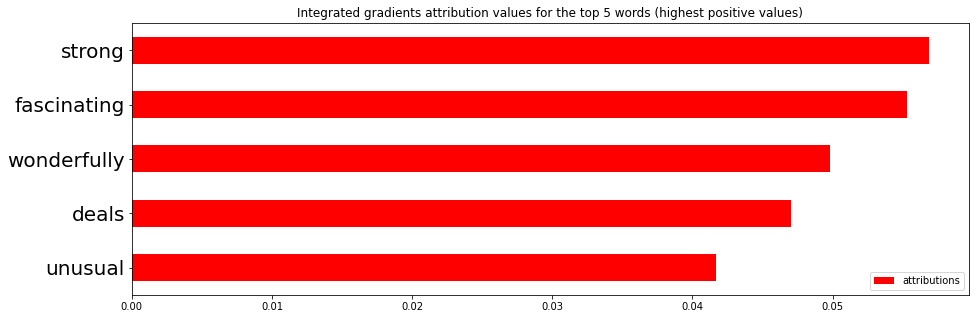

In [17]:
show_ig_text_attrs(x_i, attrs=attrs_i, top_bottom='top', color='red', reverse_index=reverse_index,
                   title='Integrated gradients attribution values for the top 5 words (highest positive values)')

Next, we visualize the attribution values for the 5 words (highlighted in the text) having the lowest negative attributions. 
Words with low negative attribution (high absolute values) may be interpreted as the words that contributed the most to decrease the probability of the predicted class "Positive review".

a powerful study of loneliness sexual UNK and desperation be patient UNK up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to UNK a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet


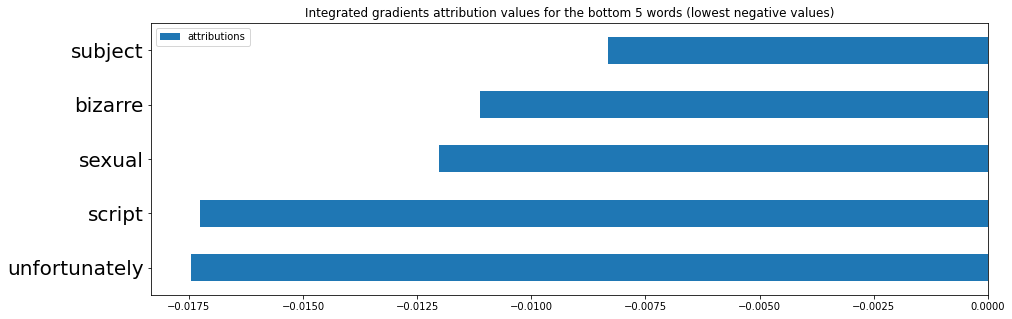

In [18]:
show_ig_text_attrs(x_i, attrs=attrs_i, top_bottom='bottom', color='blue', reverse_index=reverse_index, 
                   title='Integrated gradients attribution values for the bottom 5 words (lowest negative values)')